**Animal Performance on W-Track** 

**Set up**

In [590]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sys import argv
import matplotlib.pyplot as pyplot
import matplotlib.ticker as plt_ticker

In [ ]:
#base_name = '20230531_154845' #'20230531_150338'
#data_directory = f'/home/zoldello/Documents/data/L5/r2/{base_name}/'
#  L5/20230502/r2



base_name = '20230531_150338'
data_directory = f'/home/phil/Documents/Data/L5/r1/20230531_150338'
/home/phil/Documents/Data/20230502/r2/20230502_163824

dio_directory = f'{base_name}.DIO'
time_directory = f'{base_name}.time'
# trodes_directory = '/home/zoldello/Apps/Trodes_2-4-0_Ubuntu2004/'
trodes_directory =  ' /home/phil/Apps/Trodes_2-4-0_Ubuntu2004/'
dio_path = f'{data_directory}/{dio_directory}/{base_name}'

full_file_path = f'{data_directory}/{base_name}.rec'
trodesexport_runner = f'{trodes_directory}trodesexport'

In [ ]:
!$trodesexport_runner -rec {full_file_path} -dio -time

**Trodes' Functions**

In [ ]:
# Main function
def readTrodesExtractedDataFile(filename):
    with open(filename, 'rb') as f:
        # Check if first line is start of settings block
        if f.readline().decode('ascii').strip() != '<Start settings>':
            raise Exception("Settings format not supported")
        fields = True
        fieldsText = {}
        for line in f:
            # Read through block of settings
            if(fields):
                line = line.decode('ascii').strip()
                # filling in fields dict
                if line != '<End settings>':
                    vals = line.split(': ')
                    fieldsText.update({vals[0].lower(): vals[1]})
                # End of settings block, signal end of fields
                else:
                    fields = False
                    dt = parseFields(fieldsText['fields'])
                    fieldsText['data'] = np.zeros([1], dtype = dt)
                    break
        # Reads rest of file at once, using dtype format generated by parseFields()
        dt = parseFields(fieldsText['fields'])
        data = np.fromfile(f, dt)
        fieldsText.update({'data': data})
        return fieldsText


# Parses last fields parameter (<time uint32><...>) as a single string
# Assumes it is formatted as <name number * type> or <name type>
# Returns: np.dtype
def parseFields(fieldstr):
    # Returns np.dtype from field string
    sep = re.split('\s', re.sub(r"\>\<|\>|\<", ' ', fieldstr).strip())
    # print(sep)
    typearr = []
    # Every two elmts is fieldname followed by datatype
    for i in range(0,sep.__len__(), 2):
        fieldname = sep[i]
        repeats = 1
        ftype = 'uint32'
        # Finds if a <num>* is included in datatype
        if sep[i+1].__contains__('*'):
            temptypes = re.split('\*', sep[i+1])
            # Results in the correct assignment, whether str is num*dtype or dtype*num
            ftype = temptypes[temptypes[0].isdigit()]
            repeats = int(temptypes[temptypes[1].isdigit()])
        else:
            ftype = sep[i+1]
        try:
            fieldtype = getattr(np, ftype)
        except AttributeError:
            print(ftype + " is not a valid field type.\n")
            exit(1)
        else:
            typearr.append((str(fieldname), fieldtype, repeats))
    return np.dtype(typearr)

**Time**

In [ ]:
times_dat = readTrodesExtractedDataFile(f'{data_directory}/{time_directory}/{base_name}.timestamps.dat')
#time = readTrodesExtractedDataFile(f'/stelmo/kyu/L5/20230502/r2/20230502_163824/20230502_163824.time/20230502_163824.timestamps.dat')

In [ ]:
trodes_ptp_time_map = pd.DataFrame({
    'trodes_time': times_dat['data']['time'],
    'ptp': times_dat['data']['systime']
}, columns=['trodes_time', 'ptp'])

**Functions**

In [ ]:
def convert_trode_time_list_to_ptp(trodes_times):
    trodes_ptp_time_map0 = trodes_ptp_time_map.iloc[0]['ptp']
    return np.array([
        (trodes_ptp_time_map[trodes_ptp_time_map['trodes_time']==tt]['ptp'].values[0] - trodes_ptp_time_map0) / pow(10, 9)
            if len(trodes_ptp_time_map[trodes_ptp_time_map['trodes_time']==tt]['ptp']) > 0
            else 0
        for tt in trodes_times.tolist()
    ])

In [580]:
def separate_reward_by_state(poke_rewards):
    rewarded_poke_rewards_time = [];
    rewarded_poke_rewards_state = [];
    non_rewarded_poke_rewards_time = [];
    non_rewarded_poke_rewards_state = [];
    reward_times = poke_rewards['time']
    reward_states = poke_rewards['reward_state']
    for i, reward_state in np.ndenumerate(reward_states):
        index = i[0]
        if reward_state == 0:
            non_rewarded_poke_rewards_state.append(reward_state)
            non_rewarded_poke_rewards_time.append(reward_times[index])
        else:
            rewarded_poke_rewards_state.append(reward_state)
            rewarded_poke_rewards_time.append(reward_times[index])

    return (
            np.array(rewarded_poke_rewards_state),
            np.array(rewarded_poke_rewards_time),
            np.array(non_rewarded_poke_rewards_state),
            np.array(non_rewarded_poke_rewards_time),
     )

In [591]:
def y_format(x, y):
    if y == 1:
        return 'Right'
    elif y == 3:
        return 'Center'
    elif y == 5:
        return 'Left'
    else:
        ''

**Dins Dat**

In [ ]:
din1_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din1.dat')
din2_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din2.dat')
din7_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din7.dat')

**Dout Dat**

In [ ]:
dout4_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout4.dat')
dout5_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout5.dat')
dout6_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout6.dat')

**Din**

In [ ]:
din1 = pd.DataFrame({
    'reward_state': din1_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(din1_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

din2 = pd.DataFrame({
    'reward_state': din2_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(din2_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

din7 = pd.DataFrame({
    'reward_state': din7_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(din7_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

**Dout**

In [ ]:
dout4 = pd.DataFrame({
    'reward_state': dout4_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(dout4_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

dout5 = pd.DataFrame({
    'reward_state': dout5_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(dout5_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

dout6 = pd.DataFrame({
    'reward_state': dout6_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(dout6_dat['data']['time'])
}, columns=['reward_state', 'ptp'])


**Get Poke and Reward Map**

In [ ]:
def map_poke_and_reward(din, dout):
    din_length = len(din)
    rat_time_at_reward_well = 18
    trodes_delay = 0.5
    din_index = 0
    poke_and_reward = {
        'reward_state': [],
        'time': []
    }
    
    while din_index < din_length - 1:
        current_din_time = din.iloc[din_index]['ptp']
        skip_loop = (
            din_index % 2 == 1 or
            current_din_time == 0.0
        )
        
        if skip_loop:
            din_index += 1
            continue
        
        data_query = f'ptp >= {current_din_time - trodes_delay} and ptp < {current_din_time + rat_time_at_reward_well}'
        din_data = din.query(data_query)
        din_data_length = len(din_data)
        
        if din_data_length == 0:
            din_index += 1
            continue
        
        dout_data = dout.query(data_query)
        dout_data_length = len(dout_data)
        reward_state = 1 if dout_data_length > 0 and dout_data['reward_state'].sum() > 0 else 0
        # poke_and_reward.append({
        #     'reward': reward_state,
        #     'time': current_din_time
        # })
        poke_and_reward['reward_state'].append(reward_state)
        poke_and_reward['time'].append(current_din_time)
        din_index = din_data.index[din_data_length - 1] + 1
    return {
        'reward_state': np.array(poke_and_reward['reward_state']),
        'time': np.array(poke_and_reward['time'])
    }

**Poke and Rewards**

In [ ]:
poke_and_reward_1 = map_poke_and_reward(din1, dout4)
poke_and_reward_2 = map_poke_and_reward(din2, dout5)
poke_and_reward_7 = map_poke_and_reward(din7, dout6)

**Poke/Reward splitting**

In [581]:
(rewarded_poke_rewards_state_1,
rewarded_poke_rewards_time_1,
non_rewarded_poke_rewards_state_1,
non_rewarded_poke_rewards_time_1) = separate_reward_by_state(poke_and_reward_1)

(rewarded_poke_rewards_state_2,
rewarded_poke_rewards_time_2,
non_rewarded_poke_rewards_state_2,
non_rewarded_poke_rewards_time_2) = separate_reward_by_state(poke_and_reward_2)

(rewarded_poke_rewards_state_7,
rewarded_poke_rewards_time_7,
non_rewarded_poke_rewards_state_7,
non_rewarded_poke_rewards_time_1) = separate_reward_by_state(poke_and_reward_7)

**Plots**

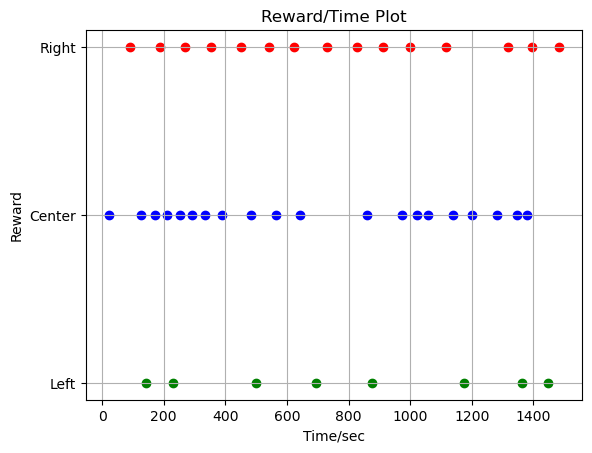

In [600]:
from numpy import *
import math
import matplotlib.pyplot as plt

t = linspace(0, 1500, 100)
a = sin(t)
b = cos(t)
c = a + b

# plt.scatter(poke_and_reward_1['time'], poke_and_reward_1['reward_state'], c='r') # plotting t, a separately 
# plt.scatter(poke_and_reward_2['time'], poke_and_reward_2['reward_state'] + 2, c='b') # plotting t, b separately 
# plt.scatter(poke_and_reward_7['time'], poke_and_reward_7['reward_state'] + 4, c='g') # plotting t, c separately 



##################################################################################
# import numpy as np
# from matplotlib import pyplot as plt
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
# x = np.array([0, 2, 4, 6])
# y = np.array([1, 3, 5, 7])
# ticks = ['a', 'b', 'c', 'd']
# plt.xticks(x, ticks)
# plt.yticks(y, ticks)
# plt.plot(x, y, c='green')
# plt.margins(x=0, y=0)
# plt.show()
#######################################################################################


ax = plt.axes()
# ax.set_yticks([0, 1, 2, 3, 4, 5])
# ax.set_yticklabels(['', 'Right', '', 'Center', '', 'Left'])

ax.set_yticks([0, 1, 3, 5])
ax.set_yticklabels(['', 'Left', 'Center', 'Right'])



plt.scatter(rewarded_poke_rewards_time_1, rewarded_poke_rewards_state_1 + 4, c='r') # plotting t, a separately 
plt.scatter(rewarded_poke_rewards_time_2,  rewarded_poke_rewards_state_2 + 2, c='b') # plotting t, b separately 
plt.scatter(rewarded_poke_rewards_time_7,  rewarded_poke_rewards_state_7 + 0, c='g') # plotting t, c separately




plt.grid(True)
plt.ylabel ('Reward')
plt.xlabel ('Time/sec')
plt.title ('Reward/Time Plot')
plt.show()

In [ ]:
##############

In [579]:
#poke_and_reward_1['time'][4]
rewarded_poke_rewards_state_2 

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
for i, v in np.ndenumerate(poke_and_reward_1['reward_state']):
    print(v)

In [564]:
rewarded_poke_rewards_state_7

[1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
linspace(0, 1500, 101)

**Get Info on Poke time and reward**

In [ ]:
reward_well_1_poke_time, reward_well_1_rewarded = map_poke_and_reward(din1_dio, din1_time, dout4_dio, dout4_time)
reward_well_2_poke_time, reward_well_2_rewarded = map_poke_and_reward(din2_dio, din2_time, dout5_dio, dout5_time)
reward_well_3_poke_time, reward_well_3_rewarded = map_poke_and_reward(din7_dio, din7_time, dout6_dio, dout6_time)

In [ ]:
##################

In [ ]:
#####
#din1[din1['ptp'] > 4].index[0]
#din1.iloc[1]['ptp']
#dout4[dout4['ptp']>91 | dout4['ptp'] < (91 +15)]
#t = dout4.query('ptp > 501 and ptp < (501+100)')
#dout4
#din1.iloc[0]['ptp']

map_poke_and_reward(din2, dout5)

#len(din2)

In [ ]:
dout4.iloc[0]

In [ ]:
#map_poke_and_reward(din1_dio, din1_time, dout4_dio, dout4_time)
#map_poke_and_reward(din2_dio, din2_time, dout5_dio, dout5_time)

map_poke_and_reward(din7_dio, din7_time, dout6_dio, dout6_time)

#[d for i,d in enumerate(din2_time) if i % 2 == 0]
#[d for i,d in enumerate(dout4_time) if i % 2 == 1]#map_poke_and_reward(din7_dio, din7_time, dout6_dio, dout6_time)


#dout4_time
#[d for i,d in enumerate(dout4_time) if i % 2 == 1]
#dout4_time
#din1_dio


#[d for i,d in enumerate(din1_time) if i % 2 == 0]
#[d for i,d in enumerate(dout4_time) if i % 2 == 1]

#[d for i,d in enumerate(din2_time) if i % 2 == 0]
#[d for i,d in enumerate(dout4_time) if i % 2 == 1]

#[d for i,d in enumerate(din7_time) if i % 2 == 0]
#[d for i,ddin7_time in enumerate(dout4_time) if i % 2 == 1]

#din1_time

In [ ]:
din1['data']['state']

In [ ]:
x = []
for i in din1['data']['time']:
    x.append(times['data']['systime'][np.nonzero(times['data']['time']==i)[0][0]])
x = np.asarray(x)
print(x)

In [ ]:
x = (x - x[0]) * 1e-9

In [ ]:
print(x)

In [ ]:
x
#times

In [ ]:
din1_time

In [ ]:
poke_time, rewarded = map_poke_and_reward(din1_dio, din1_time, dout4_dio, dout4_time)


fig, ax = plt.subplots()
ax.plot(poke_time, rewarded, **{'color': 'blue', 'marker': 'o'})


ax.plot(poke_time, rewarded, **{'color': 'red', 'marker': 'o'})




#map_poke_and_reward(din7_dio, din7_time, dout6_dio, dout6_time)

#din1_time

In [ ]:
# dout4_time
din7
# [ v for i,v in enumerate(dout4_time) if i % 2 == 0]
#din7_time
din1_time

In [ ]:
# print(din1['data'])
# print('---')
# print(din2['data'])
# print('---')
# print(din7['data'])

print(din1_time)
print('---')
print(din2_time)
print('---')
print(din7_time)

In [ ]:
time_data[time_data == 4932631]

#din1['data']['time']

In [ ]:
din1

In [ ]:
dout4_time_ptp

In [ ]:
convert_ptp_to_seconds_starting_at_first_time(dout4_time_ptp)

In [ ]:
dout4_dio

In [ ]:
[((i - 1685570658686448628)/1000000000) for i in dout4_time_ptp]
#(dout4_time_ptp)
#len(dout4_dio)

In [ ]:
din1_dio[45:50]

In [ ]:
[((i - 1685570658686448628)/1000000000) for i in din1_time_ptp][45:200]
#len(din1_dio)

**Data Expansion**

In [ ]:
def get_accuracy(din, dout):
    din_data = din['data']
    dout_data = dout['data']
    din_data_length = len(din_data)
    dout_data_length = len(dout_data)
    dout_index = 1
    dout_time = dout_data[1][0]
    pump_delay_unit = 1000
    correctness = []
    
    for i in range(0, din_data_length, 2):
        din_time = din_data[i][0] + pump_delay_unit
        current_correctness = 1 if (din_time >= dout_time) else 0
        correctness.append(current_correctness)
        
        if (current_correctness == 1):
            dout_index += 2
            
            if (dout_index == dout_data_length):
                break
            
            dout_time = dout_data[dout_index][0]
    
    return correctness
    

**Get Din Data for Plotting**

In [ ]:
def format_din_for_plotting(din):
    data = din['data']
    data_length = len(data)
    formatted_data = []
    dataX = []
    dataY = []
    dataX0 = data[0][0]
    
    for i in range(data_length):
        data_item = data[i]
        dataX.append((data_item[0]))
        dataY.append(data_item[1])
        
    return dataX, dataY

# def format_din_for_plotting(din):
#     data = din['data']
#     data_length = len(data)
#     timestamp_at_creation = din['timestamp_at_creation']
#     last_time_stamp = data[data_length - 1][0]
#     time_range = last_time_stamp - int(timestamp_at_creation)
#     dataX = [0 for _ in range(time_range)]
#     dataY = [0 for _ in range(time_range)]
    
#     for i in range(data_length):
#         dataY[i] = data[i][1]

#     return dataX, dataY

    

In [ ]:

plt.figure(figsize=(20, 20))
x = format_din_for_plotting(din1)
plt.bar(x[0][0:100], x[1][0:100], color='black', edgecolor='black', linewidth=0.3)
plt.show()

plt.figure(figsize=(20, 20))
y = format_din_for_plotting(dout4)
plt.bar(y[0][0:100], y[1][0:100], color='red', edgecolor='red', linewidth=0.3)
plt.show()

# y = format_din_for_plotting(dout4)
# plt.plot(np.array(y[0]), np.array(y[1]))
# plt.show()


# pop = [22,55,62,45,21,22,34,42,42,4,2,8]
# bins = [1,10,20,30,40,50]
# pyplot.hist(pop, bins, rwidth=0.6)


In [ ]:
##################### function ###########################3
ptp_times = []
def convert_trodes_time_to_ptp(trodes_times: None):
    for trodes_time in trodes_times:
        for ptp_time in time['data']:
            if trodes_time == ptp_time[0]:
                ptp_times.append(ptp_time[1])
                break
    return ptp_times

In [ ]:
din1_x = []
din1_y = []
for data in din1['data']:
    din1_x.append(data[0])
    din1_y.append(data[1])

In [ ]:
dout1_x = []
dout1_y = []
for data in dout4['data']:
    dout1_x.append(data[0])
    dout1_y.append(data[1])

In [ ]:
def test_plot(x,y):
    # x = np.linspace(0,5,10)
    # y = np.array([1,0, 0, 0 , 0, 1, 1, 1,0,1])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.step(x,y,color='r')
    #ax.step(x,y+2,color='g')
#ax.set_ylim([-2,9])
#ax.set_xlim([-1,6])
    ax.legend()

    ax.draw()

In [ ]:
test_plot(din1_x, din1_y)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = [1, 0, 0, 1, 1, 0, 1, 0]
xs = np.repeat(range(len(data)), 2)
ys = np.repeat(data, 2)
xs = xs[1:]
ys = ys[:-1]
xs = np.append(xs,xs[-1] + 1)
ys = np.append(ys, ys[-1])

#ys = np.array([1,0,1,1,1,1,0,1,1])
ys = np.array([1,1,1,1,0,1,1,0,1])
xs = np.array([0,1,2,3,4,5,6,7,8])



plt.yticks([0,1])
#plt.step(din1_x, din1_y)
#plt.scatter(din1_x[:15], din1_y[:15])
#plt.step(din1_x[:5], din1_y[:5])
plt.step(xs, ys)
